In [ ]:
import sys
import warnings

import numpy as np
import plotly.io as pio

pio.renderers.default = "notebook"
warnings.filterwarnings("ignore")

sys.path.append("../src/features")
from plots import plot_ecdf, plot_ecdf_combined  # noqa: E402

## Dummy data example

In [2]:
P = 9
M = 4
N = 800
N_ROWS = 3
N_COLS = 3

ranks = [np.random.uniform(0, 1, size=(N, M)) for _ in range(P)]
param_names = [f"Parameter {i + 1}" for i in range(P)]
series_names = [f"Series {i + 1}" for i in range(M)]

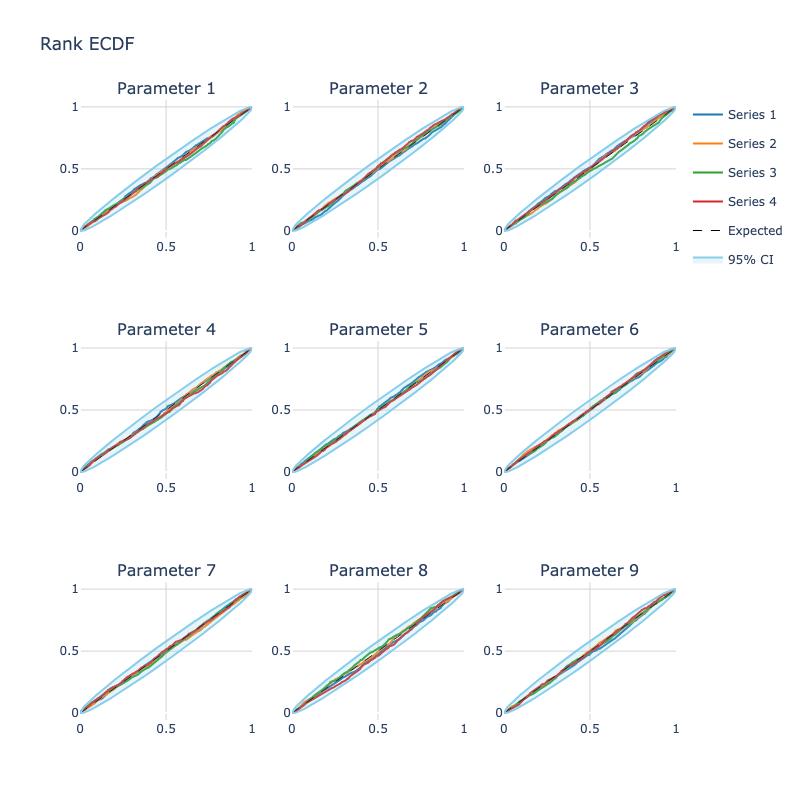

In [3]:
fig1 = plot_ecdf(
    ranks,
    param_names=param_names,
    series_names=series_names,
    n_rows=N_ROWS,
    n_cols=N_COLS,
)
fig1.update_layout(height=800)
fig1.show("png")

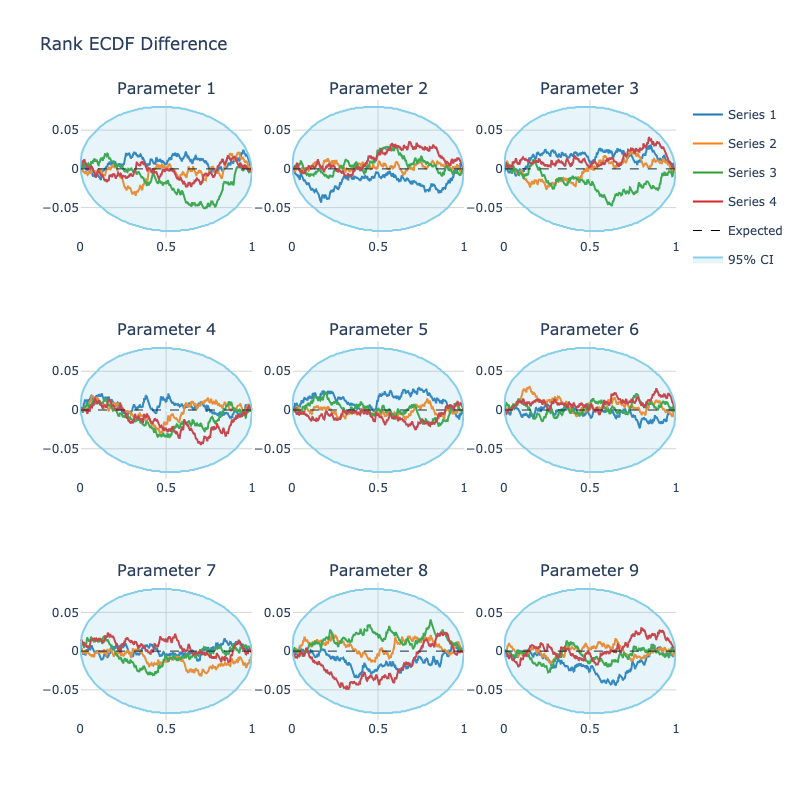

In [4]:
fig2 = plot_ecdf(
    ranks,
    param_names=param_names,
    series_names=series_names,
    is_diff=True,
    n_rows=N_ROWS,
    n_cols=N_COLS,
)
fig2.update_layout(height=800)
fig2.show("png")

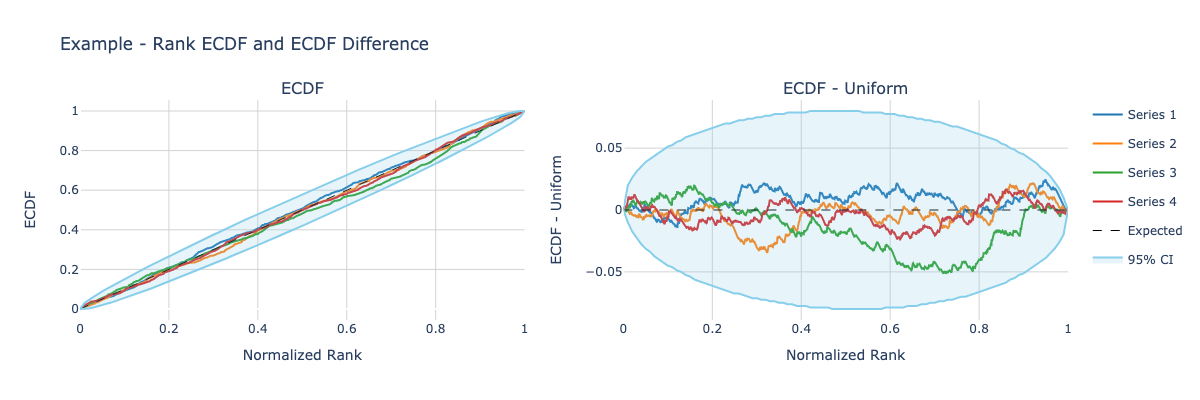

In [5]:
fig3 = plot_ecdf_combined(ranks[0], param_name="Example", series_names=series_names)
fig3.update_layout(width=1200)
fig3.show("png")

## Normal Prior Examples

In [6]:
import os

from analysis import calculate_ranks
from utils import load_model_setup

os.chdir("..")


def plot_model_results(model_name, var_name):
    ranks = calculate_ranks(model_name)
    setup = load_model_setup(model_name)
    n_sims = len(setup["data"])
    n_chains = setup["chains"]

    chain_names = [f"chain_{i}" for i in range(n_chains)]
    sample = np.zeros((n_sims, n_chains))

    for chain in range(n_chains):
        sample[:, chain] = ranks[var_name][chain]

    fig = plot_ecdf_combined(sample, var_name, chain_names)
    fig.update_layout(height=500, width=1200)
    fig.show("png")

### Bad Prior Example

In this example, we have a simple model where:

1. Data is generated from a Normal distribution with:
   - Mean ($\mu$) = 1
   - Standard deviation ($\sigma$) = 1
   - Only 1 observation per simulation

2. The Stan model specifies:
   - Prior: $\mu \sim \mathcal{N}(0,1)$
   - Likelihood: $y_i \sim \mathcal{N}(\mu,1)$

The issue here is the misalignment between the prior and the true data:
- The prior is centered at 0
- But the data is generated with mean 1

This creates a conflict that can hinder inference, especially with few observations.
We'll see this reflected in the ECDF plots below.


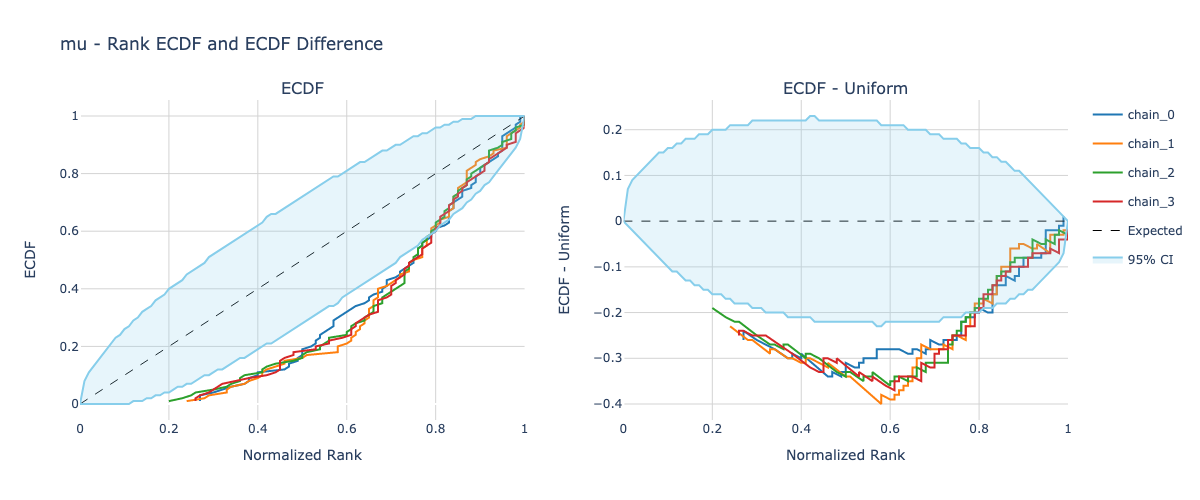

In [7]:
model_name = "bad_prior_example"
var_name = "mu"
plot_model_results(model_name, var_name)

### Nice Prior Example

In this example, we have a simple model where:

1. Data is generated from a Normal distribution with:
   - Mean ($\mu$) = 0 
   - Standard deviation ($\sigma$) = 1
   - Only 1 observation per simulation

2. The Stan model specifies:
   - Prior: $\mu \sim \mathcal{N}(0,1)$
   - Likelihood: $y_i \sim \mathcal{N}(\mu,1)$

This represents a well-specified model where the prior aligns with the true data generating process:
- The prior is centered at 0, matching the true mean
- The prior variance of 1 provides reasonable uncertainty
- The likelihood correctly specifies the data distribution


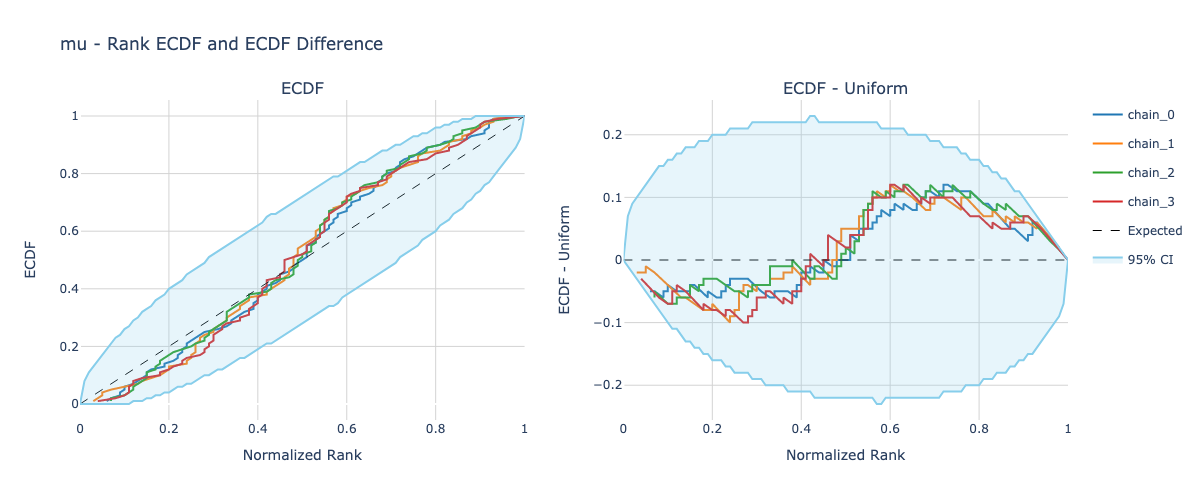

In [8]:
model_name = "nice_prior_example"
var_name = "mu"
plot_model_results(model_name, var_name)